In [1]:
#####
# Matteson Research Lab
# Code by Ethan Goolish
# https://github.com/egoolish/ecp
# cc: Fret Dynamics Lab
#####

In [2]:
## If this is your first time running the code, you will need to download and import the ecp package:
# pip install git+https://github.com/egoolish/ecp_python

In [3]:
#import needed packages

import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
import time
import pandas as pd
from ecp import e_divisive, e_agglomerative
%matplotlib inline

In [4]:
# ts is the time series to be analyzed
# num_states is the number of states in the model (default: 4)
# ms is the minimum segment size (default: 2)
# alpha is the exponential for the distance matrix (default: 2)
# K is the number of change points to look for in the initial e_divisive call (default: 100)

def fret_model(ts, num_states=4, ms=2, alpha=2, K=100):

#######################################
# Helper Functions:

    # Helper function for the intra-matrix distance calculation.
    def get_within(alpha, X):
        alpha = float(alpha)
        ret = 0.0
    
        n = X.shape[0]

        for i in range(n):
            for j in range(n):
                ret += np.power(np.sqrt(np.sum((X[i, :] - X[j, :]) * (X[i, :] - X[j, :]))), alpha)
        return ret/(n*n) if (n*n) != 0 else np.nan

    # Helper function for the inter-matrix distance calculation.
    def get_between(alpha, X, Y):
        alpha = float(alpha)
        ret = 0.0

        n = X.shape[0]
        m = Y.shape[0]

        for i in range(n):
            for j in range(m):
                ret += np.power(np.sqrt(np.sum((X[i, :] - Y[j, :]) * (X[i, :] - Y[j, :]))), alpha)
        return (2*ret)/float(n*m) if (n*m) != 0 else np.nan

    # Helper function for custom agglomerative segmentation
    def agglo_method(alpha, n, ts, cluster, k):
        ret = {"order": [], "cluster": cluster}
        curr_n = n
        if curr_n <= k:
            return ret

        within = np.zeros(n)
        for i in range(n):
            working_ts = ts[cluster==i]
            if working_ts.ndim == 1: working_ts = np.reshape(working_ts, (len(working_ts), 1))
            within[i] = get_within(alpha, working_ts)

        dflat = np.zeros(int(((n*n)-n)/2))
        idx = 0
        md = [] #maps from the linear index to the tuple (i, j) in the non-flattened distance matrix

        for i in range(n):
            for j in range(i+1, n):
                working_ts1 = ts[cluster==i]
                working_ts2 = ts[cluster==j]
                if working_ts1.ndim == 1: working_ts1 = np.reshape(working_ts1, (len(working_ts1), 1))
                if working_ts2.ndim == 1: working_ts2 = np.reshape(working_ts2, (len(working_ts2), 1))
                d = get_between(alpha, working_ts1, working_ts2) - within[i] - within[j]
                dflat[idx] = d
                idx += 1
                md.append((i, j))
        while(curr_n > k):
            min_idx = np.nanargmin(dflat)
            i, j = md[min_idx]
            ret["order"].append((i, j))


            cluster[cluster==j] = i
            working_ts = ts[cluster == i]
            if working_ts.ndim == 1: working_ts = np.reshape(working_ts, (len(working_ts), 1))
            new_within = get_within(alpha, working_ts)
            within[i] = new_within
            within[j] = new_within

            for idx in range(n):
                if idx != j and idx != i:
                    working_ts1 = ts[cluster==i]
                    working_ts2 = ts[cluster==idx]
                    if working_ts1.ndim == 1: working_ts1 = np.reshape(working_ts1, (len(working_ts1), 1))
                    if working_ts2.ndim == 1: working_ts2 = np.reshape(working_ts2, (len(working_ts2), 1))
                    d = get_between(alpha, working_ts1, working_ts2) - within[i] - within[idx]

                    if idx < i:
                        flat_idx = int(((2*idx*n) - (idx*idx) + (2*i) - (3*idx) - 2)/2)
                        dflat[flat_idx] = d
                    elif idx > i:
                        flat_idx = int(((2*i*n) - (i*i) + (2*idx) - (3*i) - 2)/2)
                        dflat[flat_idx] = d

                    if idx < j:
                        flat_idx = int(((2*idx*n) - (idx*idx) + (2*j) - (3*idx) - 2)/2)
                        dflat[flat_idx] = np.inf
                    elif idx > j:
                        flat_idx = int(((2*j*n) - (j*j) + (2*idx) - (3*j) - 2)/2)
                        dflat[flat_idx] = np.inf
                elif idx == j:
                    t1, t2 = (i, j) if i < j else (j, i)
                    flat_idx = int(((2*t1*n) - (t1*t1) + (2*t2) - (3*t1) - 2)/2)
                    dflat[flat_idx] = np.inf  

                    flat_idx = int(((2*t2*n) - (t2*t2) + (2*t1) - (3*t2) - 2)/2)
                    dflat[flat_idx] = np.inf
            curr_n = len(np.unique(cluster))
        ret["cluster"] = cluster
        return ret 
    
    # End helper functions.
    ######################################
    
    sol_dict = e_divisive.e_divisive(X = ts, k=K, alpha=alpha, min_size=ms)
    plt.figure(figsize=(20,10))
    plt.plot(ts)
    for xc in sol_dict['estimates']:
        plt.axvline(x=xc, color='r', linestyle=':')
        
    point_labels = agglo_method(alpha=2, n=len(sol_dict['estimates'])-1, ts=np.copy(ts), cluster=np.copy(sol_dict['cluster']), k=num_states)["cluster"]
    final_ests = [sol_dict['estimates'][0]]
    seg_labels = [point_labels[0]]
    for i in range(1, len(point_labels)):
        if point_labels[i] != point_labels[i-1]:
            final_ests.append(i)
            seg_labels.append(point_labels[i])
    final_ests.append(sol_dict['estimates'][-1])
    final_ests = np.array(final_ests)
    seg_labels = np.array(seg_labels)
    
    lens = np.diff(final_ests)
    find_avg_time = np.vectorize(lambda x : np.mean(lens[seg_labels == x]))
    avg_times = find_avg_time(np.unique(seg_labels))
    
    P_diag = np.vectorize(lambda x : (x - 1)/x)(avg_times)

    est_P = np.zeros((num_states, num_states))
    fixed_labels = np.copy(seg_labels)
    unq = np.unique(seg_labels)
    for i in range(len(unq)):
        fixed_labels[fixed_labels == unq[i]] = i

    for i in range(1, len(seg_labels)):
        est_P[fixed_labels[i-1], fixed_labels[i]] += 1
    np.fill_diagonal(est_P, 0)
    est_P = normalize(est_P, axis = 1, norm='l1')
    est_P = (est_P.T*(1 - P_diag)).T
    np.fill_diagonal(est_P, P_diag)
    
    plt.figure(figsize=(20,10))
    plt.plot(ts)
    final_ests = final_ests - 0.5
    for xc in final_ests:
        plt.axvline(x=xc, color='r', linestyle=':')
    mx = np.max(ts)
    diff_labs = np.unique(seg_labels)
    for i in range(len(seg_labels)):
        if seg_labels[i] == diff_labs[0]:
            plt.fill_betweenx([0, mx], final_ests[i], final_ests[i+1], facecolor='green', alpha=0.10)
        elif seg_labels[i] == diff_labs[1]:
            plt.fill_betweenx([0, mx], final_ests[i], final_ests[i+1], facecolor='red', alpha=0.10)
        elif seg_labels[i] == diff_labs[2]:
            plt.fill_betweenx([0, mx], final_ests[i], final_ests[i+1], facecolor='yellow', alpha=0.10)
        elif seg_labels[i] == diff_labs[3]:
            plt.fill_betweenx([0, mx], final_ests[i], final_ests[i+1], facecolor='blue', alpha=0.10)
        else:
            plt.fill_betweenx([0, mx], final_ests[i], final_ests[i+1], facecolor='orange', alpha=0.10)

    print("Estimated P: ")
    print(est_P)
    return

In [14]:
#data takes in the path to the txt data
#spl is how many points to take

data = pd.read_csv("fret_data/binned_ms_4.txt", sep=",")
spl = 500

d1 = data['n_accept'][:spl]
d2 = data['n_donor'][:spl]
ts = data['effi'][:spl]
new_ts = np.stack((d1, ts, d2), axis=-1)

Estimated P: 
[[0.96992481 0.03007519 0.         0.         0.        ]
 [0.00662252 0.98344371 0.00331126 0.00331126 0.00331126]
 [0.         0.05       0.95       0.         0.        ]
 [0.         0.05       0.         0.95       0.        ]
 [0.04       0.         0.         0.         0.96      ]]


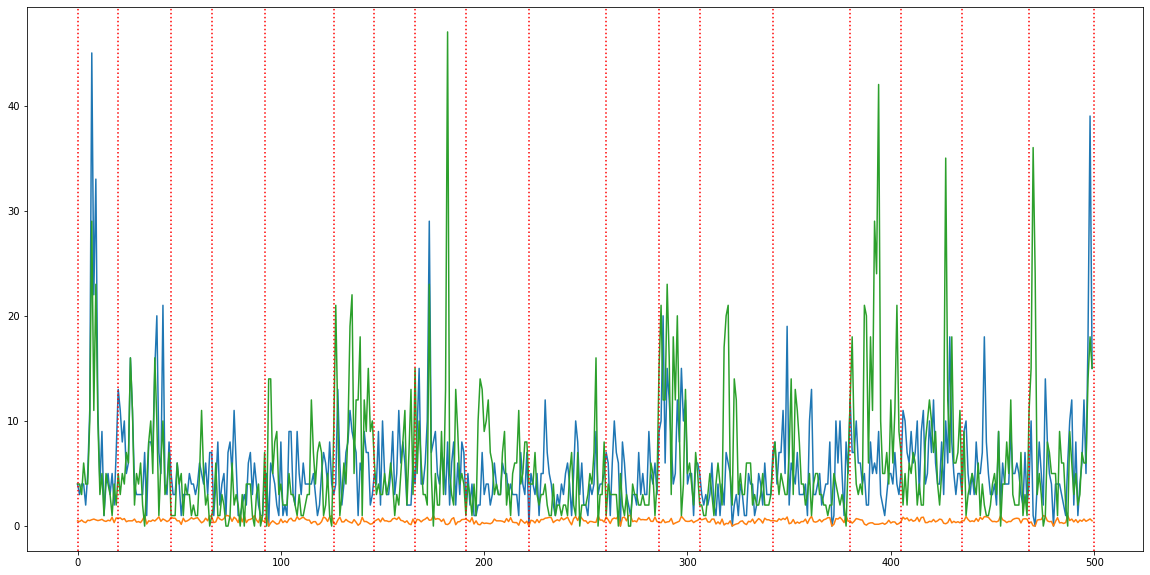

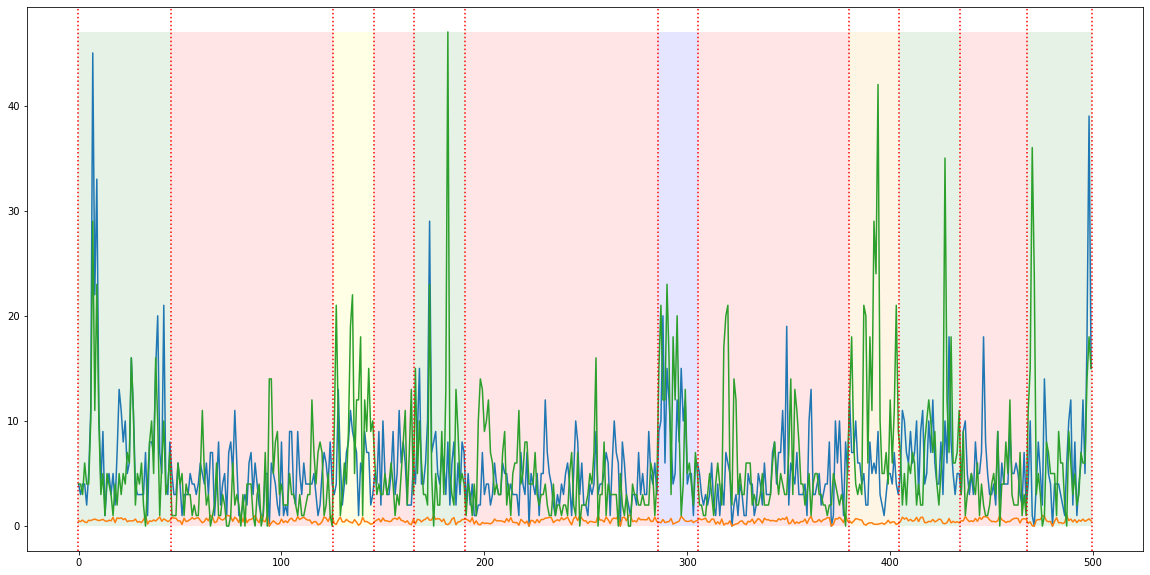

In [15]:
# should take ~30 seconds for a time series of 500
fret_model(new_ts, num_states=5, ms=20, alpha=1, K=100)